<a href="https://colab.research.google.com/github/maricelandal/food-sales-predictions/blob/main/food_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Data

In [1]:
# Mount our Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries

In [2]:
# Imports
import numpy as np
import pandas as pd

# Load Data

In [3]:
# Load Data

file = ('/content/drive/MyDrive/Coding Dojo/Week 1/sales_prediction/sales_predictions_2023.csv')

df = pd.read_csv(file)

# Check first 5 rows

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Exploratory Data Analysis (EDA)


In [4]:
# check the shape

df.shape

# The dataset has 8,523 rows and 12 columns.

(8523, 12)

In [5]:
# or checking for rows

len(df)

# The datasset has 8,523 rows

8523

In [6]:
# or checking for columns

len(df.columns)

# The datasset has 12 columns

12

In [7]:
# check the datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
# check duplicates

df.duplicated().sum()

# The dataset has no duplicate values.

0

In [9]:
# check if there are missing values

df.isna().sum()

# There are 1,463 missing values under Item_Weight and 2,410 missing values under Outlet_Size

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
# check statistics

df.describe()

# for numerical columns, use df.describe() - to check min, max, mean

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [11]:
# check for values of dtypes == object

dtypes = df.dtypes

object_cols = dtypes[dtypes == 'object'].index
object_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [12]:
# check the values in each object columns using for loop to check any inconsistencies and value counts

for cols in object_cols:
  print(f'Column = {cols}')
  print(df[cols].value_counts(dropna = False))
  print('\n')

# Item_Weight and Outlet_Size value counts to check which method to use in filling in missing values
# There are irregularity or inconsitency in the column 'Item_Fat_Content'
# We should replace 'LF' and 'low fat' with 'Low Fat'
# We should also replace 'reg' with 'Regular'

Column = Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Column = Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Column = Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Column = Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT0

In [13]:
# check for values of dtypes == float

dtypes = df.dtypes

number_cols = dtypes[dtypes == 'float'].index
number_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales'], dtype='object')

In [14]:
# check the values in each float columns using for loop

for num_cols in number_cols:
  print(f'Column = {num_cols}')
  print(df[num_cols].value_counts(dropna = False))
  print('\n')


# to check the mode of 'Item_Weight' which has missing values
# 12.15 is the Item_Weight which has the most frequent occurences (mode)

Column = Item_Weight
NaN       1463
12.150      86
17.600      82
13.650      77
11.800      76
          ... 
7.275        2
7.685        1
9.420        1
6.520        1
5.400        1
Name: Item_Weight, Length: 416, dtype: int64


Column = Item_Visibility
0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64


Column = Item_MRP
172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Item_MRP, Length: 5938, dtype: int64


Column = Item_Outlet_Sales
958.7520     17
1342.2528    16
703.0848     15
1845.5976    15
1278.3360    14
             ..
4124.6310     1
6622.7126     1
1614.5650     1
5602.7070     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64




In [15]:
# check for values of dtypes == int

dtypes = df.dtypes

est_year_col = dtypes[dtypes == 'int'].index
est_year_col

# We can convert this column from int to datetime

Index(['Outlet_Establishment_Year'], dtype='object')

In [16]:
# check the values in each int columns using for loop
# replace dtype
for year_col in est_year_col:
  print(f'Column = {year_col}')
  print(df[year_col].value_counts(dropna = False))


# no inconsistency under the Column 'Outlet_Establishment_Year'

Column = Outlet_Establishment_Year
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64


# EDA Results

There are missing values for columns: Item_Weight (1463), Outlet_Size (2410).

There are inconsistent or irregularity in 'Item_Fat_Content' column.

We should change the datatype of Outlet_Establishment_Year from int to datetime.

# Data Cleaning

#### Fill the missing values

In [17]:
# Imputing Missing Data Using sklearn (sklearn simple imputation has algorithm)


df['Item_Weight'].fillna(12.150, inplace=True)
# df['Item_Weight'].fillna(12.857645, inplace=True)


# For 'Item_Weight', the mean (12.85) is slightly higher than the mode (12.15)
# Will use the mode to fill the missing values (comprised 17% of total, derived using count of missing/total rows) #########
# Will use the mean to fill the missing values (comprised 17% of total, derived using count of missing/total rows)
# The 17% missing values under 'Item_Weight' should be imputed (dropping them is not advisable)


In [18]:
# Under 'Outlet_Size' column, total missing values is 2,410 (28% of total)

# Medium    2793
# NaN       2410
# Small     2388
# High       932

df['Outlet_Size'].fillna('Medium', inplace = True)

# The most frequent value under 'Outlet_Size' is medium which consist of 2,793 (33% of total)
# The next most frequesnt value is Small, which consist of 2,388 (28% of total)
# The item which has least occurence is High which consist of 932 (11% of total)
# We can use the mode (most frequent value) to fill the missing values for categorical data

In [19]:
# check if again if there are still missing values

df.isna().sum()

# After simple imputation (filling in the 'Item_Weight' with average weight), there are no more missing values
# After simple imputation (filling in the 'Outlet_Size' with Medium, which has most frequent occurences), there are no more missing values

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

#### Fix the inconsistent data under 'Item_Fat_Content'

In [20]:
# There are irregularity or inconsitency in the column 'Item_Fat_Content'

df['Item_Fat_Content'].replace('LF', 'Low Fat', inplace=True)

# We should replace 'LF' and 'low fat' with 'Low Fat'

In [21]:
# We should replace 'low fat' with 'Low Fat'

df['Item_Fat_Content'].replace('low fat', 'Low Fat', inplace=True)

In [22]:
# We should also replace 'reg' with 'Regular'

df['Item_Fat_Content'].replace('reg', 'Regular', inplace=True)

# check corrections on 'Item_Fat_Content'

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

#### Change the 'Outlet_Establishment_Year' datatype from int to datetime

In [23]:
# change date to datatype

df['Outlet_Establishment_Year'] = pd.to_datetime(df['Outlet_Establishment_Year'])

# check corrections on date datatype

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Item_Identifier            8523 non-null   object        
 1   Item_Weight                8523 non-null   float64       
 2   Item_Fat_Content           8523 non-null   object        
 3   Item_Visibility            8523 non-null   float64       
 4   Item_Type                  8523 non-null   object        
 5   Item_MRP                   8523 non-null   float64       
 6   Outlet_Identifier          8523 non-null   object        
 7   Outlet_Establishment_Year  8523 non-null   datetime64[ns]
 8   Outlet_Size                8523 non-null   object        
 9   Outlet_Location_Type       8523 non-null   object        
 10  Outlet_Type                8523 non-null   object        
 11  Item_Outlet_Sales          8523 non-null   float64       
dtypes: dat

# Data Visualization

## Univariate Exploratory Visualization

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

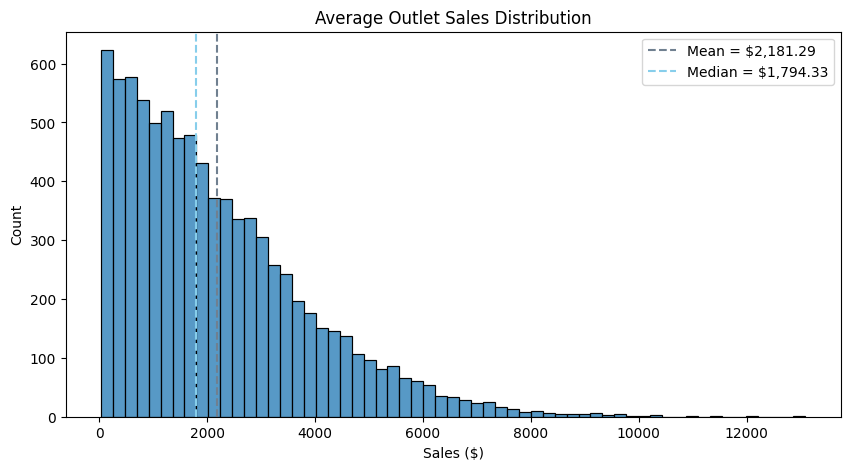

In [25]:
# Histogram of Average Outlet Sales

## Make a larger fig/ax before plotting
fig, ax = plt.subplots(figsize = (10, 5))

## Plot histogram
sns.histplot(data=df, x=round(df['Item_Outlet_Sales']), ax=ax)
ax.set(title="Average Outlet Sales Distribution")

## Annotating mean and median
mean_sales = df['Item_Outlet_Sales'].mean()
ax.axvline(mean_sales,
           color='slategray',
           ls='--',
           label=f"Mean = ${mean_sales:,.2f}")

med_sales = df['Item_Outlet_Sales'].median()
ax.axvline(med_sales,
           color='skyblue',
           ls='--',
           label=f"Median = ${med_sales:,.2f}")

# Labels and Legend
ax.set(xlabel="Sales ($)")
ax.legend();

fig;

The data suggest that the distribution of average outlet sales is positively skewed. The mean ($2,181.29) is greater than 0, the hump is on the left while it has a long tail on the right.

The concentration of average outlet sales is in the 75th percentile (Q3) - middle value between median and the highest value of dataset.

There are several outliers after the max of value of dataset as shown by its long tail.

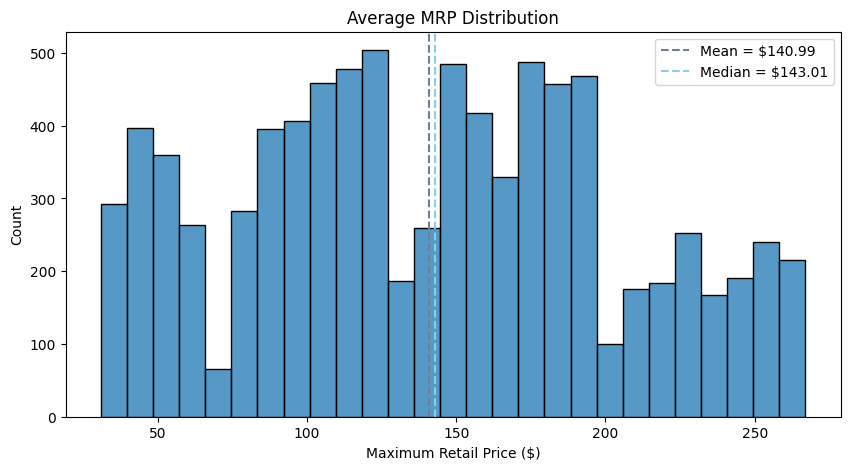

In [26]:
# Histogram of Item_MRP (Maximum Retail Price)

## Make a larger fig/ax before plotting
fig, ax = plt.subplots(figsize = (10, 5))

## Plot histogram
sns.histplot(data=df, x=round(df['Item_MRP']), ax=ax)
ax.set(title="Average MRP Distribution")

## Annotating mean and median
mean_mrp = df['Item_MRP'].mean()
ax.axvline(mean_mrp,
           color='slategray',
           ls='--',
           label=f"Mean = ${mean_mrp:,.2f}")

med_mrp = df['Item_MRP'].median()
ax.axvline(med_mrp,
           color='skyblue',
           ls='--',
           label=f"Median = ${med_mrp:,.2f}")

# Labels and Legend
ax.set(xlabel="Maximum Retail Price ($)")
ax.legend();

fig;

The data suggest that average MRP has a normal distribution. The data is symmetric and has no skew. Average MRP is close to the middle value of the dataset.

The concentration is at the mean; cluster of data points toward the middle of the range.

There are no outliers (no data points outside the horizonal black line (min and max of dataset).

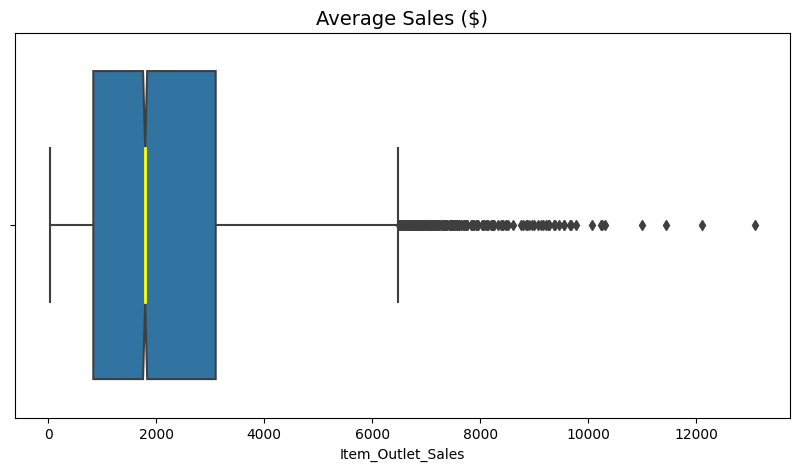

In [27]:
# seaborn
# Create figure
fig, ax = plt.subplots(figsize=(10, 5))

# Set the title
ax.set_title('Average Sales ($)', fontsize=14)

# Label and Notch
sns.boxplot(data = df,
            x = 'Item_Outlet_Sales',
            notch = True,
            medianprops=dict(linestyle='-',
            linewidth=2,
            color='Yellow'));

The data suggest that the distribution for outlet sales is positively skewed. The mean is greater than 0, hump is on the left while the tail extends to the right.

There are also several outliers as shown by data points outside the maximum value of the dataset.

<ipython-input-28-032342f55c84>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop(columns = 'Item_Type').corr()


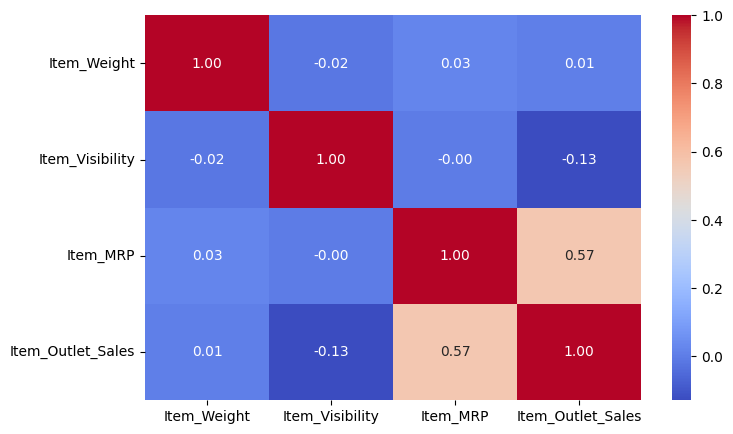

In [28]:
# heatmap
# create a var and drop ReAdmis is this was id to be irrelevant
corr = df.drop(columns = 'Item_Type').corr()

# plot the heatmap
plt.figure(figsize = (8,5))
sns.heatmap(corr, cmap = 'coolwarm', annot = True, fmt = '.2f');

# correlation bet features
# correlation table
# 0.30 - 0.50 = there is a weak + correlation
# 0.51 - 0.70 = there is a moderate + correlation
# 0.71 - 0.90 = there is a strong + correlation
# 0.91 - 1.00 = there is vstrong + correlation (perfect)

Correlation observations:

There is a moderate positive correlation between Item_MRP and Item_Outlet_Sales (0.57)

As the maximum retail price (MRP) goes up, sales also goes up; price and quantity are a function of sales so it is rational that they are positively correlated.

## Multivariate Exploratory Visualization

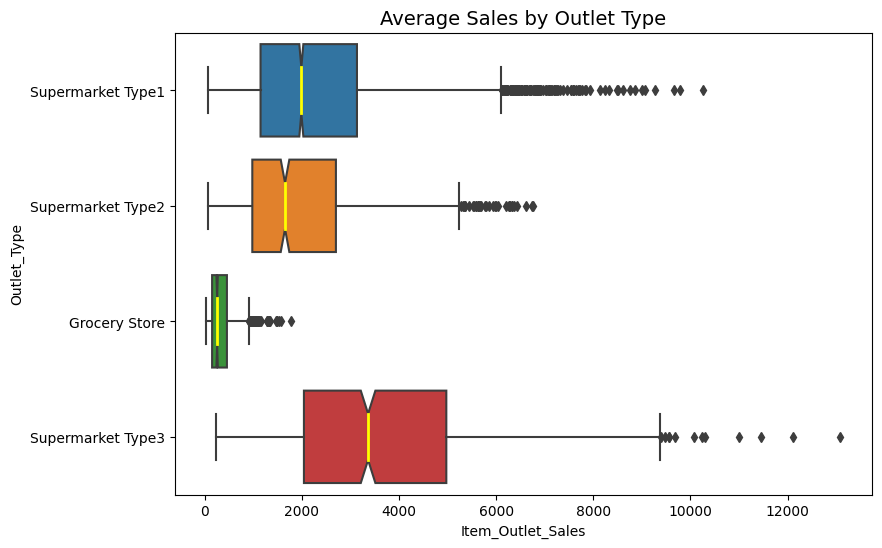

In [29]:
# Seaborn
# Create figure
fig, ax = plt.subplots(figsize=(9, 6))

# Set the title
ax.set_title('Average Sales by Outlet Type', fontsize=14)

# Labels and Notch
sns.boxplot(data = df,
            y = 'Outlet_Type',
            x = 'Item_Outlet_Sales',
            notch = True,
            medianprops=dict(linestyle='-',
            linewidth=2,
            color='Yellow'));

plt.show();

The data suggest that the distribution for all outlet type is positively skewed. The mean is greater than 0, hump is on the left while the tail extends to the right.

There are also several outliers as shown by data points outside the maximum value of the dataset.

Highest sales came from Supermarket 3 as shown by the range of sales generated from that outlet.

In [30]:
# Creat variable to group average sales by item type

avg_item_sales = df.groupby('Item_Type')['Item_Outlet_Sales'].mean()
avg_item_sales

Item_Type
Baking Goods             1952.971207
Breads                   2204.132226
Breakfast                2111.808651
Canned                   2225.194904
Dairy                    2232.542597
Frozen Foods             2132.867744
Fruits and Vegetables    2289.009592
Hard Drinks              2139.221622
Health and Hygiene       2010.000265
Household                2258.784300
Meat                     2158.977911
Others                   1926.139702
Seafood                  2326.065928
Snack Foods              2277.321739
Soft Drinks              2006.511735
Starchy Foods            2374.332773
Name: Item_Outlet_Sales, dtype: float64

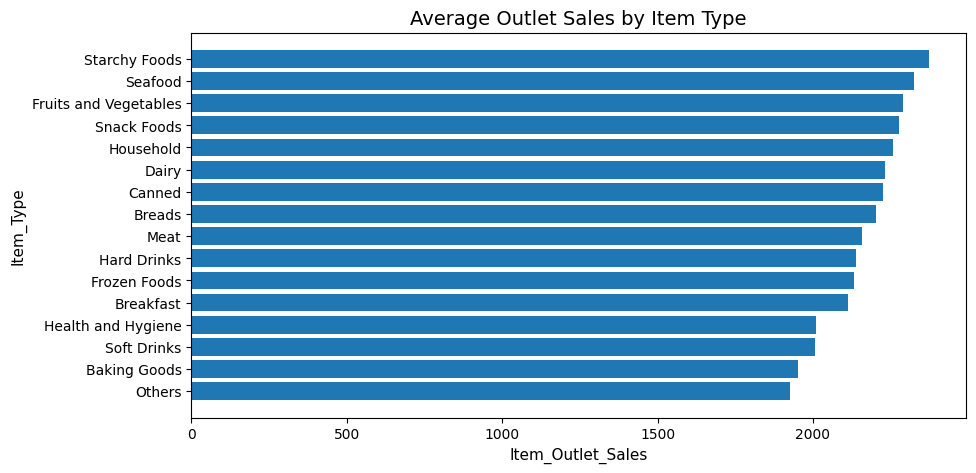

In [31]:
# use the variable to sort values by Item Type
avg_item_sales = avg_item_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,5))

# Horixontal Bar Chart
plt.barh(avg_item_sales.index, avg_item_sales.values)

# Title and Labels
plt.ylabel('Item_Type', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Outlet Sales by Item Type", fontsize=14)

plt.show();

The data suggest that among the items being sold, Starchy Foods has the highest sales, followed by Seafood and Fruits and Vegetables.

Lowest sales came from Other Items, Baking Goods and Soft Drinks.

In [32]:
# Creat variable to group average sales by outlet type

avg_type_sales = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean()
avg_type_sales

Outlet_Type
Grocery Store         339.828500
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

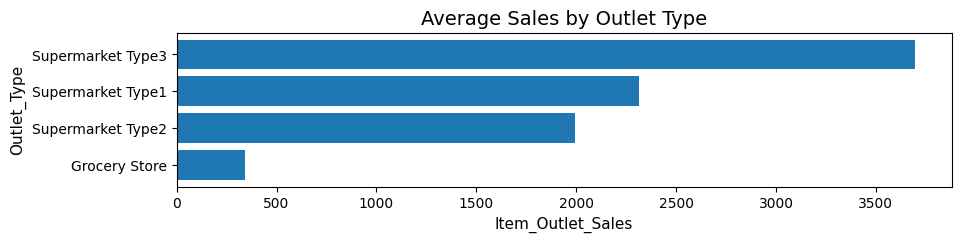

In [33]:
# use the variable to sort values by Outlet Type
avg_type_sales = avg_type_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,2))

# Horixontal Bar Chart
plt.barh(avg_type_sales.index, avg_type_sales.values)

# Title and Labels
plt.ylabel('Outlet_Type', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Sales by Outlet Type", fontsize=14)

plt.show();

The data suggest that among the four outlet types, Supermarket Type 3 generates the highest sales while the least sales-generating is Grocery Store.

It is rational that in terms of wide selection of products, Supermarket is bigger in size and higher foot traffic leads to higher sales; hence, more sales are generated in supermarket compared to grocery store.

In [34]:
# Creat variable to group average sales by outlet size

avg_outlet_sales = df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean()
avg_outlet_sales

Outlet_Size
High      2298.995256
Medium    2283.730470
Small     1912.149161
Name: Item_Outlet_Sales, dtype: float64

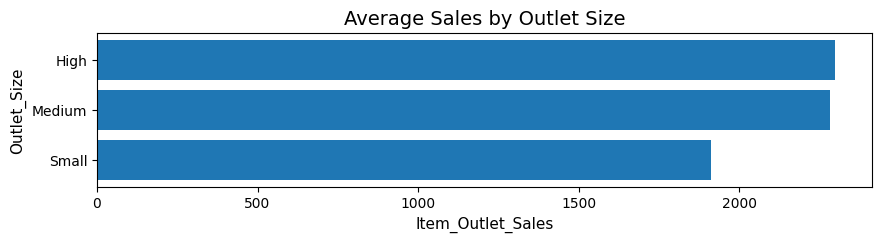

In [35]:
# use the variable to sort values by Outlet Size
avg_outlet_sales = avg_outlet_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,2))

# Horixontal Bar Chart
plt.barh(avg_outlet_sales.index, avg_outlet_sales.values)

# Title and Labels
plt.ylabel('Outlet_Size', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Sales by Outlet Size", fontsize=14)

plt.show();

The data suggest that higher sales are generated from High and Medium Outlet Size.

The data also suggest that size and type of outlets determine potential sales. As shown in previous chart, Supermarket (bigger in terms of size compared to grocery store) generate higher sales.

In [36]:
# Creat variable to group average sales by outlet location type

avg_loc_sales = df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean()
avg_loc_sales

Outlet_Location_Type
Tier 1    1876.909159
Tier 2    2323.990559
Tier 3    2279.627651
Name: Item_Outlet_Sales, dtype: float64

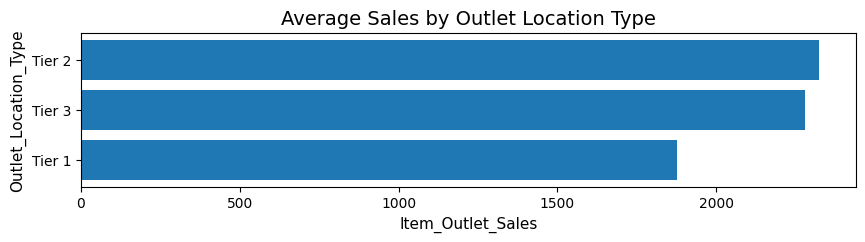

In [37]:
# use the variable to sort values by Outlet Type
avg_loc_sales = avg_loc_sales.sort_values()

# Plot the Figure
plt.figure(figsize=(10,2))

# Horixontal Bar Chart
plt.barh(avg_loc_sales.index, avg_loc_sales.values)

# Title and Labels
plt.ylabel('Outlet_Location_Type', fontsize=11)
plt.xlabel('Item_Outlet_Sales', fontsize=11)
plt.title("Average Sales by Outlet Location Type", fontsize=14)

plt.show();

The data suggest that more sales are generated from Tier 2 followed by Tier 3 Outlet Location.

Among the three outlet location, Tier 1 generated the lowest sales.